# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [54]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import mean, datediff, max, min, round,ceil,split,trim
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer,VectorAssembler,StandardScaler
from pyspark.ml.classification import LogisticRegression,GBTClassifier,LinearSVC,RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator

import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import datetime 
import time
import numpy as np

%matplotlib inline

In [55]:
# create a Spark session
spark=SparkSession.builder.appName('Data Frames spark').getOrCreate()

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [56]:
#加载数据mini_sparkify_event_data.json
df=spark.read.json('mini_sparkify_event_data.json')
df.createOrReplaceTempView('log_table')

In [57]:
#查询数据及结构
df.printSchema()
spark.sql("select count(0) from log_table").show()
spark.sql("select count(0) from log_table where userId = ''").show()
spark.sql("select distinct auth from log_table ").show()
spark.sql("select distinct level from log_table ").show()
spark.sql("select distinct status from log_table ").show()
spark.sql("select distinct ts from log_table ").show()
spark.sql("select distinct page from log_table ").show()
spark.sql("select auth,level,iteminsession,page,registration,status,\
          ts,userid from log_table where \
          page in ('Cancel','Submit Downgrade','Downgrade','Roll Advert','Logout')\
          and level ='paid'\
          order by ts desc").show(1)

spark.sql("select auth,level,iteminsession,page,registration,status,\
          ts,userid from log_table where \
          userid='100007'\
          order by ts desc").show(1) 

spark.sql("select * from log_table").show(5) 

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

+--------+
|count(0)|
+--------+
|  286500|
+--------+

+--------+
|count(0)|
+--------+
|    8346|
+--------+

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+------+
|status|
+------+
|   307|
|  

In [58]:
spark.sql("select distinct location from log_table ").show(3,False)

+--------------------------------------+
|location                              |
+--------------------------------------+
|Gainesville, FL                       |
|Atlantic City-Hammonton, NJ           |
|Deltona-Daytona Beach-Ormond Beach, FL|
+--------------------------------------+
only showing top 3 rows



In [9]:
#查询空的数据
spark.sql("select count(0) from log_table where userId = '' or userId is null" ).show()
spark.sql("select count(0) from log_table where gender = '' or gender is null").show()
spark.sql("select count(0) from log_table where length = '' or length is null").show()
spark.sql("select count(0) from log_table where level = '' or level is null").show()
spark.sql("select count(0) from log_table where location = '' or location is null").show()
spark.sql("select count(0) from log_table where Page = '' or Page is null").show()
spark.sql("select count(0) from log_table where registration = '' or registration is null").show()
spark.sql("select count(0) from log_table where ts = '' or ts is null").show()

#spark.sql("select 'gender','length','level','location','Page',\
#          'registration','ts','userID' from log_table ").show(1)

+--------+
|count(0)|
+--------+
|    8346|
+--------+

+--------+
|count(0)|
+--------+
|    8346|
+--------+

+--------+
|count(0)|
+--------+
|   58392|
+--------+

+--------+
|count(0)|
+--------+
|       0|
+--------+

+--------+
|count(0)|
+--------+
|    8346|
+--------+

+--------+
|count(0)|
+--------+
|       0|
+--------+

+--------+
|count(0)|
+--------+
|    8346|
+--------+

+--------+
|count(0)|
+--------+
|       0|
+--------+



In [59]:
#清理数据，删除userid为空的数据
df = df.filter(df.userId != '')
#其他为空的数据怎么处理？
#avg(df.length)
#df.select(avg("length")).show()
df = df.fillna(249.1171819778458)
#spark.sql("select 'gender','length','level','location','Page','registration','ts','userID' from log_table ").show(1)
#增加area从location中提取区域信息
df=df.withColumn('area',trim(split(df.location, ',')[1]))

In [60]:
#验证空值清理的情况
df.filter(df.length.isNull()).show(5)
df.filter(df.userId.isNull()).show(5)
df.filter(df.userId == '').show(5)
df.select('area').dropDuplicates().orderBy('area').show(50)

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+----+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|area|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+----+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+----+

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+----+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|area|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+-----

In [61]:
#获取年月日方法
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).weekday(),IntegerType())
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).month,IntegerType())
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).day,IntegerType())

In [62]:
#根据registration衍生出了3个特征，分别是年月日
df = df.withColumn('registration_weekday',get_weekday(df.registration))
df = df.withColumn('registration_month',get_month(df.registration))
df = df.withColumn('registration_day',get_day(df.registration))
#根据ts衍生出了3个特征，分别是年月日
df = df.withColumn('ts_weekday',get_weekday(df.ts))
df = df.withColumn('ts_month',get_month(df.ts))
df = df.withColumn('ts_day',get_day(df.ts))

In [63]:
#定义一个窗口来筛选前后数据
user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
#定义Cancellation Confirmation为用户取消的标示
isCancel=udf(lambda x: int(x == 'Cancellation Confirmation'),IntegerType())
#筛选数据，把用户取消的标示同步到所有的数据
cusm = df.select('gender','length','location','Page','registration','ts','userID','registration_weekday'
                ,'registration_month','registration_day','ts_weekday','ts_month','ts_day','area')\
    .filter(df.level == 'paid')\
    .withColumn('Churn', Fsum(isCancel(df.page)).over(user_window))\
    .withColumn('ts_length', ceil((max('ts').over(user_window)-min('ts').over(user_window))/86400000))

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失
在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

In [64]:
cusm.take(5)

[Row(gender='M', length=249.1171819778458, location='Chicago-Naperville-Elgin, IL-IN-WI', Page='Thumbs Up', registration=1536269906000, ts=1542324354000, userID='200002', registration_weekday=3, registration_month=9, registration_day=6, ts_weekday=3, ts_month=11, ts_day=15, area='IL-IN-WI', Churn=0, ts_length=29),
 Row(gender='M', length=149.57669, location='Chicago-Naperville-Elgin, IL-IN-WI', Page='NextSong', registration=1536269906000, ts=1542324353000, userID='200002', registration_weekday=3, registration_month=9, registration_day=6, ts_weekday=3, ts_month=11, ts_day=15, area='IL-IN-WI', Churn=0, ts_length=29),
 Row(gender='M', length=202.91873, location='Chicago-Naperville-Elgin, IL-IN-WI', Page='NextSong', registration=1536269906000, ts=1542324151000, userID='200002', registration_weekday=3, registration_month=9, registration_day=6, ts_weekday=3, ts_month=11, ts_day=15, area='IL-IN-WI', Churn=0, ts_length=29),
 Row(gender='M', length=252.96934, location='Chicago-Naperville-Elgin,

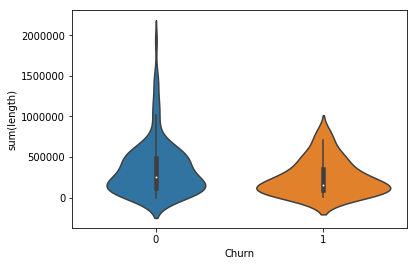

In [65]:
#查看length对于不同状态Churn的情况
cusm_length = cusm.select('userID','Churn','length')\
                  .groupby('userID','Churn')\
                  .sum('length').toPandas()
#cusm_length.head(10)
sb.violinplot(data = cusm_length, x = 'Churn', y = 'sum(length)')

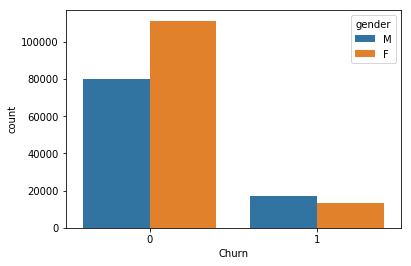

In [66]:
#查看gender对于不同状态Churn的情况
cusm_gender = cusm.select('userid','Churn','gender').toPandas()
cusm_gender.head(10)
sb.countplot(data = cusm_gender,x = 'Churn',hue = 'gender')

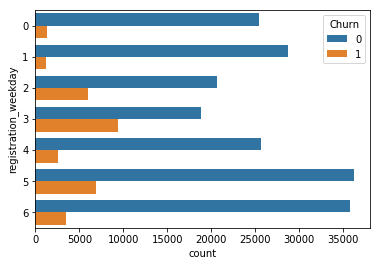

In [67]:
#查看registration_weekday对于不同状态Churn的情况
cusm_gender = cusm.select('userid','Churn','registration_weekday').toPandas()
cusm_gender.head(10)
sb.countplot(data = cusm_gender,y = 'registration_weekday',hue = 'Churn')

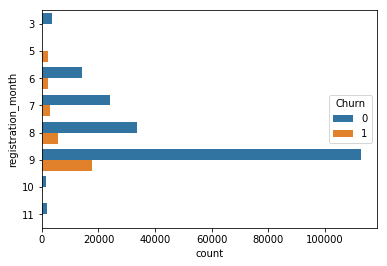

In [68]:
#查看registration_month对于不同状态Churn的情况
cusm_gender = cusm.select('userid','Churn','registration_month').toPandas()
cusm_gender.head(10)
sb.countplot(data = cusm_gender,y = 'registration_month',hue = 'Churn')

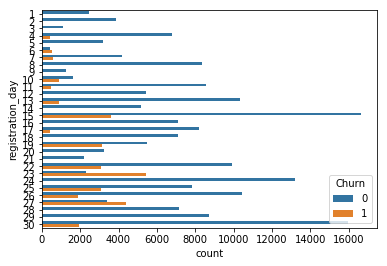

In [69]:
#查看registration_day对于不同状态Churn的情况
cusm_gender = cusm.select('userid','Churn','registration_day').toPandas()
cusm_gender.head(10)
sb.countplot(data = cusm_gender,y = 'registration_day',hue = 'Churn')

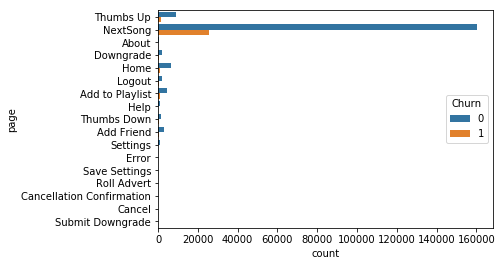

In [70]:
#查看page对于不同状态Churn的情况
cusm_level = cusm.select('userid','Churn','page').toPandas()
cusm_level.head(10)
sb.countplot(data = cusm_level,y = 'page',hue = 'Churn')

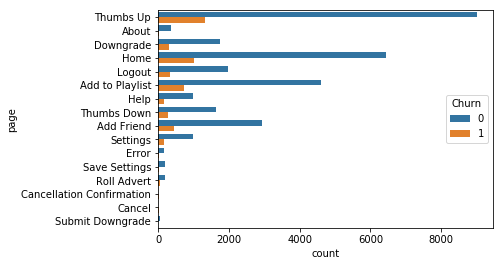

In [71]:
#查看page对于不同状态Churn的情况,筛选掉NextSong的数据
cusm_level_2 = cusm.select('userid','Churn','page').filter(cusm.Page != 'NextSong').toPandas()
#cusm_level_2.head(10)
sb.countplot(data = cusm_level_2,y = 'page',hue = 'Churn')

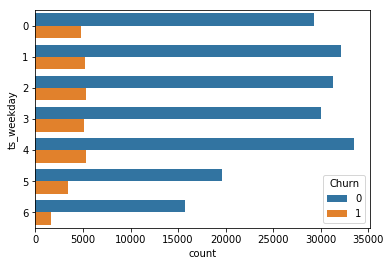

In [72]:
#查看ts_weekday对于不同状态Churn的情况
cusm_gender = cusm.select('userid','Churn','ts_weekday').toPandas()
#cusm_gender.head(10)
sb.countplot(data = cusm_gender,y = 'ts_weekday',hue = 'Churn')

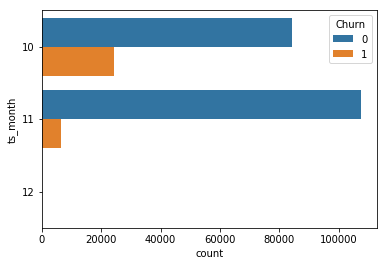

In [73]:
#查看ts_month对于不同状态Churn的情况
cusm_gender = cusm.select('userid','Churn','ts_month').toPandas()
#cusm_gender.head(10)
sb.countplot(data = cusm_gender,y = 'ts_month',hue = 'Churn')

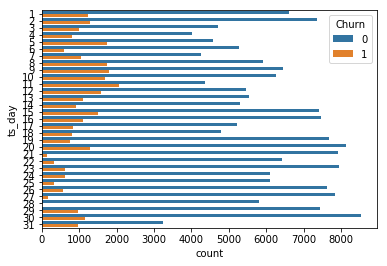

In [74]:
#查看ts_day对于不同状态Churn的情况
cusm_gender = cusm.select('userid','Churn','ts_day').toPandas()
#cusm_gender.head(10)
sb.countplot(data = cusm_gender,y = 'ts_day',hue = 'Churn')

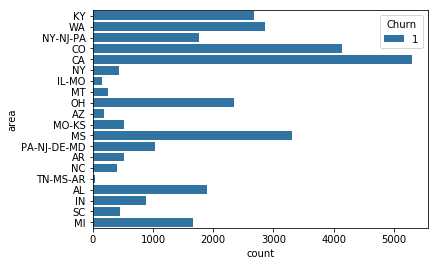

In [75]:
#查看area对于churn为1的情况
cusm_gender = cusm.select('userid','Churn','area').filter(cusm.Churn == 1).toPandas()
#cusm_gender.head(10)
sb.countplot(data = cusm_gender,y = 'area',hue = 'Churn')

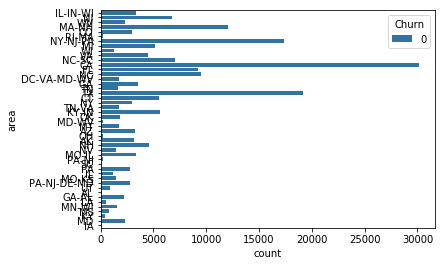

In [76]:
#查看area对于churn为0的情况
cusm_gender = cusm.select('userid','Churn','area').filter(cusm.Churn == 0).toPandas()
#cusm_gender.head(10)
sb.countplot(data = cusm_gender,y = 'area',hue = 'Churn')

(array([ 8.,  4.,  5.,  3.,  4.,  0.,  1.,  4.,  0.,  2.]),
 array([  1. ,   6.8,  12.6,  18.4,  24.2,  30. ,  35.8,  41.6,  47.4,
         53.2,  59. ]),
 <a list of 10 Patch objects>)

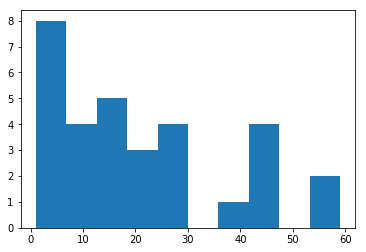

In [77]:
#查看ts_length对于churn为1的情况
cusm_tslength1 = cusm.select('userid','Churn','ts_length').filter(cusm.Churn == 1).distinct().toPandas()
plt.hist(data = cusm_tslength1, x = 'ts_length')
#cusm_gender.head(10)
#sb.countplot(data = cusm_tslength1,y = 'ts_length',hue = 'Churn')
#sb.countplot(data = cusm_tslength1,y = 'ts_length',hue = 'Churn')


(array([ 14.,   3.,   6.,  11.,  11.,  10.,  11.,  14.,  19.,  35.]),
 array([  0. ,   6.1,  12.2,  18.3,  24.4,  30.5,  36.6,  42.7,  48.8,
         54.9,  61. ]),
 <a list of 10 Patch objects>)

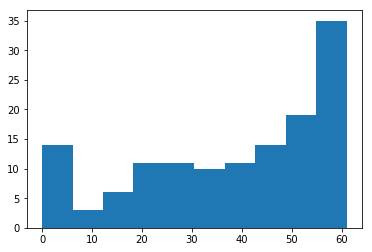

In [78]:
#查看ts_length对于churn为0的情况
cusm_tslength2 = cusm.select('userid','Churn','ts_length').filter(cusm.Churn == 0).distinct().toPandas()
plt.hist(data = cusm_tslength2, x = 'ts_length')

In [25]:
#df.filter(df.Churn == 1).select(['userid','Churn']).show(10)
#df=df.drop('artist')
#df.select('userId').groupby('userId').count().sort('count',ascending = False).show(10)
#df.select('page').groupby('page').count().sort('count',ascending = False).show(10)

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

In [79]:
#经过分析，gender和length的数据差异较小，其余特征较明显，提取明显的特征生成一个原始的特征数据集
#包含'ts_weekday', 'registration_weekday', 'ts_month', 'registration_month', 'page','area', 'churn','ts_length'
df_data_raw = cusm.select('ts_weekday', 'registration_weekday', 'ts_month', 'registration_month', 'page','area', 'churn','ts_length')
#将列churn修改为标签，label列
df_data_raw = df_data_raw.withColumnRenamed('churn', 'label')

In [80]:
#定义特征缩放，特征合并
areaIndexer = StringIndexer(inputCol='area', outputCol='area_feature')
pageIndexer = StringIndexer(inputCol='page', outputCol='page_feature')
assembler = VectorAssembler(inputCols=['ts_weekday', 'registration_weekday', 'ts_month', 'registration_month', 'area_feature', 'page_feature', 'ts_length'], outputCol='features_vec')
standardScaler = StandardScaler(inputCol='features_vec', outputCol='features')
# 定义评估指标；labelCol原始列，predictionCol预测列
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

In [81]:
#将数据中的特征进行转化
df_data = areaIndexer.fit(df_data_raw).transform(df_data_raw)
df_data = pageIndexer.fit(df_data).transform(df_data)
df_data = assembler.transform(df_data)
df_data = standardScaler.fit(df_data).transform(df_data)

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [82]:
#处理过特征的数据集拆分
df_train, df_test = df_data.randomSplit([0.8, 0.2], seed=45)
#未处理过的特征的数据集拆分，用于后续的管道数据
df_train_raw, df_test_raw = df_data_raw.randomSplit([0.8, 0.2], seed=45)
#df_train.head()
#df_train_raw.head()

In [36]:
#模型1使用逻辑回归分类
#开始时间
start_time = time.time()
logist_lr = LogisticRegression(labelCol="label", featuresCol="features")
logist_model = logist_lr.fit(df_train)
logist_predict = logist_model.transform(df_test)
logist_lr_accuracy = evaluator.evaluate(logist_predict, {evaluator.metricName: "accuracy"})
logist_lr_f1score = evaluator.evaluate(logist_predict, {evaluator.metricName: "f1"})
#结束时间
end_time = time.time()

print('Run Time: {}'.format(np.round(((end_time - start_time)/60),2)))
print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(logist_lr_accuracy))
print('F-1 Score:{}'.format(logist_lr_f1score))

Run Time: 2.86
Logistic Regression Metrics:
Accuracy: 0.9005455119246202
F-1 Score:0.8920264111960107


In [38]:
#模型2使用梯度提升决策树
#开始时间
start_time = time.time()
gbt_tf_lr = GBTClassifier(labelCol="label", featuresCol="features")
gbt_tf_model = gbt_tf_lr.fit(df_train)
gbt_tf_predict = gbt_tf_model.transform(df_test)
gbt_tf_lr_accuracy = evaluator.evaluate(gbt_tf_predict, {evaluator.metricName: "accuracy"})
gbt_tf_lr_f1score = evaluator.evaluate(gbt_tf_predict, {evaluator.metricName: "f1"})
end_time = time.time()

print('Run Time: {}'.format(np.round(((end_time - start_time)/60),2)))
print('Gradient Boosted Trees Metrics:')
print('Accuracy: {}'.format(gbt_tf_lr_accuracy))
print('F-1 Score:{}'.format(gbt_tf_lr_f1score))

Run Time: 9.34
Gradient Boosted Trees Metrics:
Accuracy: 0.9990081601370543
F-1 Score:0.9990066264766313


In [50]:
#模型3支持向量机
#开始时间
start_time = time.time()
svm_tf_lr = LinearSVC(labelCol="label", featuresCol="features")
svm_tf_model = svm_tf_lr.fit(df_train)
svm_tf_predict = svm_tf_model.transform(df_test)
svm_tf_lr_accuracy = evaluator.evaluate(svm_tf_predict, {evaluator.metricName: "accuracy"})
svm_tf_lr_f1score = evaluator.evaluate(svm_tf_predict, {evaluator.metricName: "f1"})
#结束时间
end_time = time.time()

print('Run Time: {}'.format(np.round(((end_time - start_time)/60),2)))
print('SupportVectorMachine Metrics:')
print('Accuracy: {}'.format(svm_tf_lr_accuracy))
print('F-1 Score:{}'.format(svm_tf_lr_f1score))

Run Time: 53.71
SupportVectorMachine Metrics:
Accuracy: 0.8927929869943235
F-1 Score:0.8875748677620722


In [37]:
#模型4随机森林
#开始时间
start_time = time.time()
rf_tf_lr = RandomForestClassifier(labelCol="label", featuresCol="features")
rf_tf_model = rf_tf_lr.fit(df_train)
rf_tf_predict = rf_tf_model.transform(df_test)
rf_tf_lr_accuracy = evaluator.evaluate(rf_tf_predict, {evaluator.metricName: "accuracy"})
rf_tf_lr_f1score = evaluator.evaluate(rf_tf_predict, {evaluator.metricName: "f1"})
#结束时间
end_time = time.time()

print('Run Time: {}'.format(np.round(((end_time - start_time)/60),2)))
print('RandomForest Metrics:')
print('Accuracy: {}'.format(rf_tf_lr_accuracy))
print('F-1 Score:{}'.format(rf_tf_lr_f1score))

Run Time: 1.95
RandomForest Metrics:
Accuracy: 0.9575312204138677
F-1 Score:0.955139422226649


In [ ]:
#批量使用CrossValidator确认最佳参数，使用pipeline

In [20]:
# 定义 Machine learning classifiers
lr_classifier = LogisticRegression(maxIter=10,regParam=0.0,elasticNetParam=0)
gbt_classifier = GBTClassifier(maxIter=10,seed=42)
svm_classifier = LinearSVC(maxIter=10)
rf_classifier = RandomForestClassifier()
# 定义 pipelines
lr_pipeline = Pipeline(stages=[areaIndexer,levelIndexer,assembler,standardScaler, lr_classifier]);
gbt_pipeline = Pipeline(stages=[areaIndexer,levelIndexer,assembler,standardScaler, gbt_classifier]);
svm_pipeline = Pipeline(stages=[areaIndexer,levelIndexer,assembler,standardScaler, svm_classifier]);
rf_pipeline = Pipeline(stages=[areaIndexer,levelIndexer,assembler,standardScaler, rf_classifier]);

In [21]:
def getAccuracyAndF1Scores(all_cores,train_data,test_data):
    pd_results = []
    pd_results = pd.DataFrame(pd_results)
    pd_results['Evaluations'] = ['Accuracy','F1_Score']
    # 循环遍历数组
    for module_name, estimator, estimatorParamMap in all_cores:
        start_time = time.time()
        crossval = CrossValidator(estimator=estimator,
                          estimatorParamMaps=estimatorParamMap,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2)
        model = crossval.fit(train_data)
        predict = model.transform(test_data)
        evaluator = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")
        accuracy = evaluator.evaluate(predict, {evaluator.metricName: "accuracy"})
        f1score = evaluator.evaluate(predict, {evaluator.metricName: "f1"})
        
        end_time = time.time()
        print('Run Time: {}'.format(np.round(((end_time - start_time)/60),2)))
        print(module_name, 'Metrics:')
        print('Accuracy: {}'.format(accuracy))
        print('F-1 Score:{}\n'.format(f1score))
        pd_results[module_name] = [accuracy,f1score]
    return pd_results

In [22]:
# 定义 param grids，
lr_paramGrid = ParamGridBuilder() \
   .addGrid(lr_classifier.maxIter, [5, 10, 20]) \
   .build()

gbt_paramGrid = ParamGridBuilder() \
   .addGrid(gbt_classifier.maxIter, [5, 10, 20]) \
   .build()

svm_paramGrid = ParamGridBuilder() \
   .addGrid(svm_classifier.maxIter, [5, 10, 20]) \
   .build()

rf_paramGrid = ParamGridBuilder() \
   .addGrid(rf_classifier.numTrees,[10, 25, 50, 100]) \
   .build()

In [23]:
# 定义四种模型名称
all_module_names = ["Logistic Regression", "Gradient Boosted Trees", "Support Vector Machine", "Random Forest"]
# 定义CrossValidator的estimators参数
all_estimators = [lr_pipeline, gbt_pipeline, svm_pipeline, rf_pipeline]
# 定义CrossValidator的estimatorParamMaps参数
all_estimatorParamMaps = [lr_paramGrid, gbt_paramGrid, svm_paramGrid, rf_paramGrid]

# 定义遍历数组
all_module_cores = list(zip(all_module_names, all_estimators, all_estimatorParamMaps))

In [24]:
# 获取结果
cores_result =  getAccuracyAndF1Scores(all_module_cores,df_train_raw,df_test_raw)

1593741451.2618144
Logistic Regression Pipeline_e68ac9448255
Run Time: 5.66
Logistic Regression Metrics:
Accuracy: 0.894301932887835
F-1 Score:0.8870340502744383

1593741790.8247993
Gradient Boosted Trees Pipeline_4a8ed54dde98
Run Time: 22.61
Gradient Boosted Trees Metrics:
Accuracy: 0.9917726521520442
F-1 Score:0.9918056526798342

1593743147.6211643
Support Vector Machine Pipeline_420b8c9040c5
Run Time: 14.44
Support Vector Machine Metrics:
Accuracy: 0.8558597398864698
F-1 Score:0.8139691531883612

1593744013.781225
Random Forest Pipeline_5275c73006a5
Run Time: 11.25
Random Forest Metrics:
Accuracy: 0.9685276999353309
F-1 Score:0.968360115682015



# 总结
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。

Spark平台等类似的音乐平台，数据集主要包含用户的行为数据，通过分析提取了16个特征进行探索性分析，发现其中关联明显的提取登陆时间的周,提取注册时间的周, 提取登陆时间的月份,提取注册时间的月份, 提取登陆的页面，提取注册地区, 提取从最初登陆后最后一次登陆的时长，其中7个特征。部分数据经过2次处理。

经过特征提取，特征标准化归一化等处理，生成的原始的待处理数据集。

模型训练，因为该分析主要用分类模型，筛选了主要的几种分类方法，分别为 逻辑回归分类，梯度提升决策树，支持向量机，随机森林。其中逻辑回归，简单，效率好，易于并行。决策树易于理解，数据准备较简单，短时间内可得到效果，易于扩展到大型数据库。支持向量机适合小数量样本数据，可以解决高维问题，理论基础比较完善，较消计算资源。随机森林同样是决策树的一种，随机森林使用投票的策略。经过单独的训练发现，其中表现较好的为决策树分类的两种算法，其中回归算法效率最好。

单独分析后，为了能扩展到spark分布处理，通过pipeline及 CrossValidator进一步组合进行参数优化找到的合适参数在支持向量表现差，随机森林优于单独进行模型训练，猜测支持向量有过渡拟合的情况。

综合来看随机森林（Random Forest Metrics）在效率及预测得分方面综合较理想，故选用随机森林扩展训练。

挑战及改进：
1.对spark处理数据及展示的方法不熟悉，官网案例较少，花费了较长的时间。
2.前期使用的部分特征，进行分析后发现效果不理想，然后又回头查找，发现增加area特征，删除length,level等信息。
3.当前最好的模型预测得分为99%，实际超出了预期，考虑有过拟合的情况，或者提取更多的特征。